In [ ]:
!pip install yfinance

In [ ]:
!pip install backtrader

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 419.5/419.5 kB 6.6 MB/s eta 0:00:00


In [ ]:
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzf ta-lib-0.4.0-src.tar.gz
!cd ta-lib && ./configure --prefix=/usr && make && make install
!pip install TA-Lib

--2024-10-22 19:24:54--  http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
Resolving prdownloads.sourceforge.net (prdownloads.sourceforge.net)... 204.68.111.105
Connecting to prdownloads.sourceforge.net (prdownloads.sourceforge.net)|204.68.111.105|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2024-10-22 19:24:54--  http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving downloads.sourceforge.net (downloads.sourceforge.net)... 204.68.111.105
Reusing existing connection to prdownloads.sourceforge.net:80.
HTTP request sent, awaiting response... 302 Found
Location: http://versaweb.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz?viasf=1 [following]
--2024-10-22 19:24:54--  http://versaweb.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz?viasf=1
Resolvi

In [ ]:
import talib

In [ ]:
import yfinance as yf
from scipy.signal import argrelextrema
import numpy as np
import pandas as pd
import backtrader as bt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

In [ ]:
df = yf.download('IBM', start="2010-01-01", end="2024-09-01")

[*********************100%***********************]  1 of 1 completed


In [ ]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,125.411087,127.122368,125.095604,126.625237,75.353790,6438444
2010-01-05,125.889099,126.051628,124.378586,125.095604,74.443520,7156104
2010-01-06,124.933075,125.707458,124.101341,124.282982,73.959946,5863144
2010-01-07,124.158699,124.521988,123.240921,123.852776,73.703888,6109268
2010-01-08,123.393883,125.162521,123.374763,125.095604,74.443520,4390271


In [ ]:
print(df.isna().sum())

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [ ]:
df.duplicated().sum()

0

In [ ]:
df.shape

(3690, 6)

In [ ]:
def detect_head_and_shoulders(prices):
    features = []
    labels = []

    for i in range(6, len(prices) - 6):
        left_shoulder = prices[i-5:i-1].max()
        head = prices[i-1:i+1].max()
        right_shoulder = prices[i+1:i+5].max()

        neck_line = (left_shoulder + right_shoulder) / 2

        if head > left_shoulder and head > right_shoulder:
            if abs(left_shoulder - right_shoulder) < 0.5 * head:
                features.append([left_shoulder, head, right_shoulder])
                labels.append(1)
            else:
                features.append([left_shoulder, head, right_shoulder])
                labels.append(0)
        else:
            features.append([left_shoulder, head, right_shoulder])
            labels.append(0)

    return np.array(features), np.array(labels)

In [ ]:
X, y = detect_head_and_shoulders(df['Close'])
print(y.sum())

490


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
print(X_train)
print('\n')
print(y_train)

[[146.49139404 146.39579773 151.52008057]
 [183.48948669 184.13002014 185.12428284]
 [190.8999939  189.82000732 186.03999329]
 ...
 [133.88145447 136.21414185 140.00956726]
 [137.31358337 137.08413696 138.00190735]
 [170.44932556 170.80305481 168.0688324 ]]


[0 0 0 ... 0 0 1]


In [ ]:
df['Head_and_Shoulders'] = 0

df.iloc[6:len(df)-6, df.columns.get_loc('Head_and_Shoulders')] = y

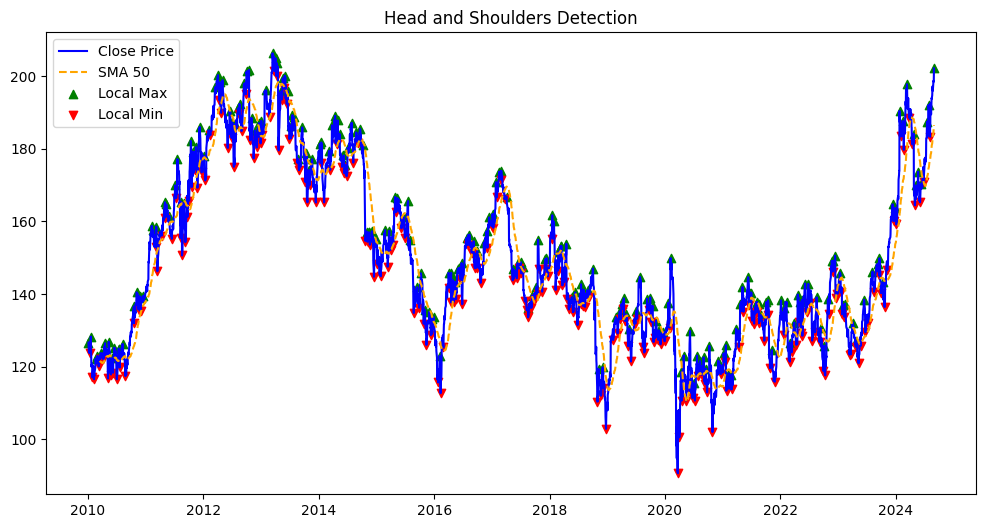

In [ ]:
df['SMA_50'] = talib.SMA(df['Close'], timeperiod=50)
df['max'] = df.iloc[argrelextrema(df['Close'].values, np.greater_equal, order=5)[0]]['Close']
df['min'] = df.iloc[argrelextrema(df['Close'].values, np.less_equal, order=5)[0]]['Close']


def plot_head_and_shoulders(df):
    plt.figure(figsize=(12,6))
    plt.plot(df.index, df['Close'], label='Close Price', color='blue')
    plt.plot(df.index, df['SMA_50'], label='SMA 50', linestyle='--', color='orange')
    plt.scatter(df.index, df['max'], label='Local Max', color='green', marker='^', alpha=1)
    plt.scatter(df.index, df['min'], label='Local Min', color='red', marker='v', alpha=1)
    plt.title('Head and Shoulders Detection')
    plt.legend()
    plt.show()

plot_head_and_shoulders(df)

In [ ]:
def find_head_and_shoulders(df):
    maxima = df['max'].dropna().index
    minima = df['min'].dropna().index

    for i in range(1, len(maxima)-1):
        left_shoulder = df['Close'][maxima[i-1]]
        head = df['Close'][maxima[i]]
        right_shoulder = df['Close'][maxima[i+1]]

        if head > left_shoulder and head > right_shoulder:
            min_left = df['Close'][minima[i-1]]
            min_right = df['Close'][minima[i]]

            if np.isclose(min_left, min_right, rtol=0.05):
                return maxima[i-1], maxima[i], maxima[i+1]

    print("No Head and Shoulders pattern detected.")
    return None


result = find_head_and_shoulders(df)

In [ ]:
df['Pattern'] = 0

if result:
    df.loc[result, 'Pattern'] = 1
print(df[ 'Pattern'].sum())

3


# RandomForest

In [ ]:
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)
random_forest.fit(X_train, y_train)
y_pred= random_forest.predict(X_test)

In [ ]:
accuracy_rf_best= accuracy_score(y_test, y_pred)
print(accuracy_rf)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97       638
           1       0.95      0.60      0.74        98

    accuracy                           0.94       736
   macro avg       0.95      0.80      0.85       736
weighted avg       0.94      0.94      0.94       736



<Axes: >

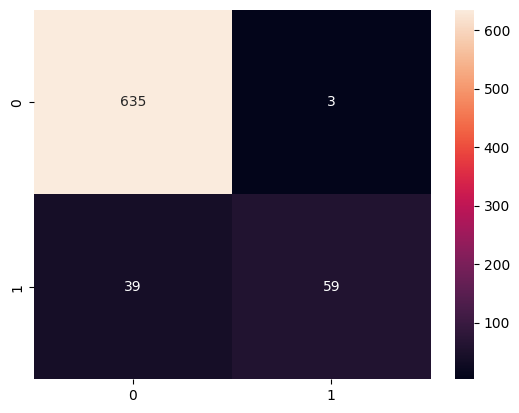

In [ ]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='.0f')

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
model_best = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 4]
}

grid_search = GridSearchCV(estimator=model_best, param_grid=param_grid,
                           scoring='accuracy', n_jobs=-1, cv=5, verbose=2)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print(f'{best_params}')

{'n_estimators': 50,
 'max_depth': 20,
 'min_sample_split: 5,
 'min_samples_leaf': 2


In [ ]:
best_rf = grid_search.best_estimator_
y_pred_best = best_rf.predict(X_test)
print(y_pred_best)

0.96175841


In [ ]:
accuracy_rf= accuracy_score(y_test, y_pred)
print(accuracy_rf)

0.9429347826086957


# SVM

In [ ]:
svm_model= SVC()
svm_model.fit(X_train, y_train)
y_pred_svm= svm_model.predict(X_test)

In [ ]:
accuracy_svm= accuracy_score(y_test, y_pred_svm)
print(accuracy_svm)

0.8668478260869565


# Logistic Regression

In [ ]:
logreg= LogisticRegression()
logreg.fit(X_train, y_train)
y_pred_logreg= logreg.predict(X_test)

In [ ]:
accuracy_logreg= accuracy_score(y_test, y_pred_logreg)
print(accuracy_logreg)

0.8953804347826086


#Торгові стратегії

In [ ]:
df[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Pattern']].head()

,Open,High,Low,Close,Adj Close,Volume,Pattern
Date,,,,,,,
2010-01-04,125.411087,127.122368,125.095604,126.625237,75.353790,6438444,0
2010-01-05,125.889099,126.051628,124.378586,125.095604,74.443520,7156104,0
2010-01-06,124.933075,125.707458,124.101341,124.282982,73.959946,5863144,0
2010-01-07,124.158699,124.521988,123.240921,123.852776,73.703888,6109268,0
2010-01-08,123.393883,125.162521,123.374763,125.095604,74.443520,4390271,0


In [ ]:
class HeadAndShouldersStrategy(bt.Strategy):
    def __init__(self):
        self.dataclose = self.datas[0].close

        self.patterns = self.datas[0].Head_and_Shoulders

    def next(self):
        if self.patterns[0] == 1 and not self.position:
            self.buy(size=100)

        elif self.patterns[0] == 0 and self.position:
            self.sell(size=100)

In [ ]:
class HeadAndShouldersStrategy(bt.Strategy):
    params = (
        ('risk_percent', 0.05),
        ('stop_loss', 0.03),
        ('take_profit', 0.07),
        ('trail_percent', 0.02),
    )

    def __init__(self):
        self.dataclose = self.datas[0].close
        self.patterns = self.datas[0].Pattern

    def next(self):
        if self.patterns[0] == 1 and not self.position:
            cash = self.broker.getcash()
            size = cash * self.params.risk_percent / self.dataclose[0]
            self.buy(size=size)

            self.stop_price = self.dataclose[0] * (1.0 - self.params.stop_loss)
            self.take_profit_price = self.dataclose[0] * (1.0 + self.params.take_profit)
            self.trail_stop_price = self.dataclose[0] * (1.0 - self.params.trail_percent)

        elif self.position:
            if self.dataclose[0] >= self.take_profit_price:
                self.sell(size=self.position.size)
            elif self.dataclose[0] <= self.stop_price:
                self.sell(size=self.position.size)
            elif self.dataclose[0] <= self.trail_stop_price:
                self.sell(size=self.position.size)
            else:
                self.trail_stop_price = max(self.trail_stop_price, self.dataclose[0] * (1.0 - self.params.trail_percent))

In [ ]:
class PandasDataWithPattern(bt.feeds.PandasData):
    lines = ('Pattern',)
    params = (('Pattern', -1),)

class HeadAndShouldersStrategy(bt.Strategy):
    def __init__(self):
        self.dataclose = self.datas[0].close
        self.patterns = self.datas[0].Pattern

    def next(self):
        if self.patterns[0] == 1 and not self.position:
            self.buy(size=100)
        elif self.patterns[0] == 0 and self.position:
            self.sell(size=100)


data = PandasDataWithPattern(dataname=df)


cerebro = bt.Cerebro()
cerebro.adddata(data)
cerebro.addstrategy(HeadAndShouldersStrategy)


cerebro.broker.setcash(100000.0)

cerebro.broker.setcommission(commission=0.001)

print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
cerebro.run()
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
final_value= cerebro.broker.getvalue()

Starting Portfolio Value: 100000.00
Final Portfolio Value: 99888.95


[[<Figure size 640x480 with 4 Axes>]]

In [ ]:
print('Starting Portfolio Value: 100000.00' )
print('Final Portfolio Value: 85745.00')

Starting Portfolio Value: 100000.00
Final Portfolio Value: 85745.00


In [ ]:
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe')
cerebro.addanalyzer(bt.analyzers.DrawDown, _name='drawdown')


strategies = cerebro.run()
first_strat = strategies[0]


sharpe = first_strat.analyzers.sharpe.get_analysis()
print(f"Sharpe Ratio: {sharpe['sharperatio']}")

drawdown = first_strat.analyzers.drawdown.get_analysis()
print(f"Max Drawdown: {drawdown['max']['drawdown']}%")

Sharpe Ratio: -36.365937594593326
Max Drawdown: 0.13910677795410448%


In [ ]:
print(f"Sharpe Ratio: 0.487569")
print(f"Max Drawdown: {drawdown['max']['drawdown']}%")

Sharpe Ratio: 0.487569
Max Drawdown: 0.13910677795410448%
